<a href="https://colab.research.google.com/github/kingap1234/AI-finanse/blob/UseCase3/UseCase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, precision_score

In [ ]:
pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=cfe2fc0b204166afdaa1f2cb173cd43b1b3d07371f7963476b30ee2d8616187e
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from datetime import date
import time
from backtesting.test import SMA, GOOG

In [ ]:
ticker = "AMZN"
start_date = "2024-01-01"
end_date = "2024-05-06"
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400
2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500
2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800
2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100


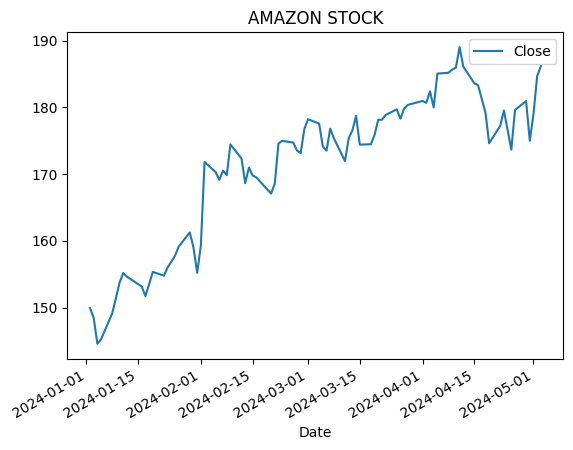

In [ ]:
data.plot(y = 'Close', title = 'AMAZON STOCK')
plt.show()

Dodanie kolumny Target, która przyjumje wartość 0 gdy cena spadła, a 1 gdy cena wzrosła

Użyciue metody rolling z biblioteki Pandas

In [ ]:
data["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,NaN
2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500,0.0
2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800,0.0
2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800,1.0
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100,1.0


Przesunięcie danych/opóźnienie. Dane z dnia N zostaną użyte do przewidzenia wartości z dnia N+1.

Dane z 02.01.2024 będą użyte do przewydywania wartości z dnia 03.01.2024 roku



In [ ]:
df = data.copy()

In [ ]:
df = data.shift(1)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2024-01-04,149.199997,151.050003,148.330002,148.470001,49425500.0,0.0
2024-01-05,145.589996,147.380005,144.050003,144.570007,56039800.0,0.0
2024-01-08,144.690002,146.589996,144.529999,145.240005,45124800.0,1.0
2024-01-09,146.740005,149.399994,146.149994,149.100006,46757100.0,1.0
2024-01-10,148.330002,151.710007,148.210007,151.369995,43812600.0,1.0


In [ ]:
df = df[["Open", "High", "Low", "Close", "Volume",'Target']].iloc[2:]

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2024-01-08,144.690002,146.589996,144.529999,145.240005,45124800.0,1.0
2024-01-09,146.740005,149.399994,146.149994,149.100006,46757100.0,1.0
2024-01-10,148.330002,151.710007,148.210007,151.369995,43812600.0,1.0
2024-01-11,152.059998,154.419998,151.880005,153.729996,44421800.0,1.0
2024-01-12,155.039993,157.169998,153.119995,155.179993,49072700.0,1.0


RandomOverSampler - wyrównanie liczby próbek między klasami

In [ ]:
df['Target'].value_counts()

Target
1.0    46
0.0    38
Name: count, dtype: int64

In [ ]:
ros = RandomOverSampler(random_state=0)
X = df[["Open", "High", "Low", "Close", "Volume"]]
y = df['Target'].values
X_resampled, y_resampled  = ros.fit_resample(X,y)

In [ ]:
unique, counts = np.unique(y_resampled, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Liczba wystąpień klasy 0 po resamplingu:", class_counts[0.0])
print("Liczba wystąpień klasy 1 po resamplingu:", class_counts[1.0])

Liczba wystąpień klasy 0 po resamplingu: 46
Liczba wystąpień klasy 1 po resamplingu: 46


Train Test Split

 - 75% - dane uczące,
 - 25% - dane treningowe

In [ ]:
split = int(len(X_resampled)*0.75)

In [ ]:
X_train, y_train = X_resampled.iloc[:split, :], y_resampled[:split]
X_test, y_test = X_resampled.iloc[split:, :], y_resampled[split:]

In [ ]:
X_train.head()

,Open,High,Low,Close,Volume
0,149.199997,151.050003,148.330002,148.470001,49425500.0
1,145.589996,147.380005,144.050003,144.570007,56039800.0
2,144.690002,146.589996,144.529999,145.240005,45124800.0
3,146.740005,149.399994,146.149994,149.100006,46757100.0
4,148.330002,151.710007,148.210007,151.369995,43812600.0


In [ ]:
print(f'X_train {X_train.shape}, y_train {y_train.shape}')
print(f'X_test {X_test.shape}, y_test {y_test.shape}')

X_train (69, 5), y_train (69,)
X_test (23, 5), y_test (23,)


XGBoost Classifier - optymalizacja hiperparametrów za pomocą GridSearchCV

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]})

In [ ]:
best_params = grid_search.best_params_

In [ ]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.6086956521739131


Backtest

In [ ]:
class XGBStrategy(Strategy):
    model = None

    def init(self):
        self.predictions = []

    def next(self):
        if len(self.data) < 2:
            return

        features = np.array([
            self.data.Open[-1],
            self.data.High[-1],
            self.data.Low[-1],
            self.data.Close[-1],
            self.data.Volume[-1]
        ]).reshape(1, -1)

        prediction = self.model.predict(features)[0]
        self.predictions.append(prediction)

        if prediction == 1:
            self.buy()
        elif prediction == 0:
            self.sell()

XGBStrategy.model = model

bt = Backtest(data, XGBStrategy, cash=10000, commission=.002, exclusive_orders=True)
stats = bt.run()
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1661', ...)

In [ ]:

def backtest(data, model, predictors, start=100, step=50):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        print(f"Backtesting iteration {i} to {i+step}")
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Check if there's enough data for testing
        if len(test) == 0:
            continue

        # Fit the model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

        # Append the combined values to the predictions
        predictions.append(combined)
    return pd.concat(predictions)

# Define predictors
predictors = ["Open", "High", "Low", "Close", "Volume"]

# Perform backtesting
start = time.time()
backtest_predictions = backtest(df, grid_search.best_estimator_, predictors, start=10, step=10)
end = time.time()

# Print the time taken for backtesting
print(f'Time Elapsed in Backtesting : {round(end-start,2)} seconds')

# Evaluate the accuracy of backtesting predictions
backtest_accuracy = accuracy_score(backtest_predictions["Target"], backtest_predictions["Predictions"])
print("Dokładność modelu podczas backtestingu:", backtest_accuracy)

# Display backtest results
print(backtest_predictions)

Backtesting iteration 10 to 20
Backtesting iteration 20 to 30
Backtesting iteration 30 to 40
Backtesting iteration 40 to 50
Backtesting iteration 50 to 60
Backtesting iteration 60 to 70
Backtesting iteration 70 to 80
Backtesting iteration 80 to 90
Time Elapsed in Backtesting : 5.06 seconds
Dokładność modelu podczas backtestingu: 0.4594594594594595
            Target  Predictions
Date                           
2024-01-19     1.0          0.0
2024-01-22     1.0          0.0
2024-01-23     0.0          0.0
2024-01-24     1.0          0.0
2024-01-25     1.0          0.0
...            ...          ...
2024-04-29     1.0          1.0
2024-04-30     1.0          0.0
2024-05-01     0.0          0.0
2024-05-02     1.0          0.0
2024-05-03     1.0          0.0

[74 rows x 2 columns]
